# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> Assignment #9


*   Youtube Lecture #36-40
*   Written by Seungeun Lee

## 1. Vanilla GAN
*     Reference. https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py, https://github.com/Yangyangii/pytorch-practice/blob/master/GAN.ipynb, https://arxiv.org/pdf/1406.2661

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import numpy as np
import datetime
import os
import sys
from matplotlib.pyplot import imshow, imsave
%matplotlib inline # 필요한 라이브러리를 불러오는 코드

In [2]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img # 생성자(Generator)에 랜덤으로 샘플링된 벡터를 넣어서 이미지를 생성하는 함수이다.

In [4]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1): # Generator에서 나온 이미지를 받는다. Discriminator는 받은 이미지가 가짜인지 진짜인지 구분하기 때문에 num_classes=1이다.
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(), # sigmoid를 이용하여 참과 거짓을 판별
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [5]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784): # 이미지를 생성해내는 Generator를 구성하는 함수이다.
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28) # 나온 벡터를 이미지릐 형태로 변환시켜 주는 과정이다.
        return y_

In [6]:
n_noise = 100

In [7]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [9]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17990261.95it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 493989.84it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4518332.92it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10292019.86it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [10]:
batch_size = 64
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [11]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999)) # D와 G는 번갈아가면서 학습을 진행하기 때문에 각각의 파라미터와 옵티마이저를 따로 설정해주어야 한다.

In [12]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [13]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [14]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [15]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels) # 실제 입력값을 넣었을 때 D의 Loss이다.

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes) # G가 만들어낸 값을 넣었을 때 D의 Loss이다.
        D_loss = D_x_loss + D_z_loss # 두개의 Loss를 합쳐 만든 최종 Loss이다.

        D.zero_grad()
        D_loss.backward()
        D_opt.step() # D를 먼저 n_critic 번 학습한다.

        if step % n_critic == 0: # n_critic 번 학습한 후 G를 학습한다.
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 0, D Loss: 1.4119584560394287, G Loss: 0.666092038154602
Epoch: 0/50, Step: 500, D Loss: 1.3430731296539307, G Loss: 1.003773808479309
Epoch: 1/50, Step: 1000, D Loss: 1.2608058452606201, G Loss: 0.7389712333679199
Epoch: 1/50, Step: 1500, D Loss: 1.3098853826522827, G Loss: 1.2423455715179443
Epoch: 2/50, Step: 2000, D Loss: 1.219523310661316, G Loss: 1.2010926008224487
Epoch: 2/50, Step: 2500, D Loss: 1.1495789289474487, G Loss: 1.005117416381836
Epoch: 3/50, Step: 3000, D Loss: 1.258570671081543, G Loss: 0.8948105573654175
Epoch: 3/50, Step: 3500, D Loss: 1.1082737445831299, G Loss: 1.271270513534546
Epoch: 4/50, Step: 4000, D Loss: 1.2245593070983887, G Loss: 0.8228490948677063
Epoch: 4/50, Step: 4500, D Loss: 1.2975232601165771, G Loss: 1.200108528137207
Epoch: 5/50, Step: 5000, D Loss: 1.1809489727020264, G Loss: 1.0003018379211426
Epoch: 5/50, Step: 5500, D Loss: 1.1687979698181152, G Loss: 0.8063050508499146
Epoch: 6/50, Step: 6000, D Loss: 1.2490582466125488

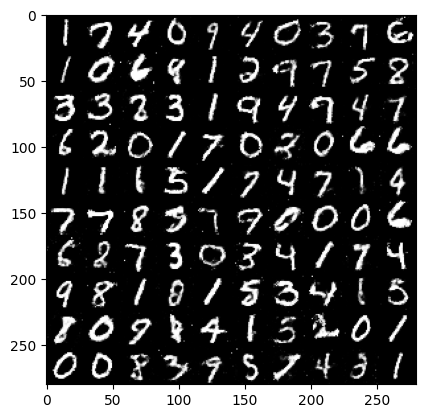

In [16]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray') # 학습된 G를 이용해서 만든 이미지를 보여준다.

In [17]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')

### Question 1. Explain the code of the '1. Vanilla GAN' section "briefly".

## GAN(Generative Adversarial Network) : GAN은 임의의 분포를 갖는 데이터를 입력받고 가짜 데이터를 생성하는 Generator(생성자)와 실제 데이터와 가짜 데이터를 구별하는 Discriminator(판별자)를 구성하여 이미지를 생성하는 생성 모델이다.


## GAN은 학습을 진행 할 때 Generator와 Discriminator를 번갈아가면서 학습을 진행한다. 대부분의 경우에 Discriminator를 먼저 학습한 뒤에 Generator를 학습하게 된다. G와 D의 학습 과정은 게임 이론에서 말하는 minmax 문제와 유사하다. 이 문제의 해답은 Nash equilibrium으로써 D^*(x) = 1/2로 수렴하는 것이 최적의 답이다.

## GAN의 장점은 비지도 학습이라 데이터에 라벨을 붙이지 않아도 학습을 할 수 있다. 또한, VAE와 다르게 좀 더 높은 질의 이미지를 생성할 수 있다.

## GAN의 단점은 G와 D의 수렴이 보장되지 않는다는 것이다. 만약, G와 D가 Nash Equilibrium에 도달하지 않는다면 GAN은 학습이 되지 않게 될 수 있다. 또한, Mode collapse 현상이 일어 날 수 있다. Mode collapse 현상은 G가 D를 속이기 위해서 데이터의 다양성을 잃어버리는 현상을 뜻한다.

## 2014년에 vanilla GAN이 나온 후 여러 가지 버전의 GAN이 개발 되었다.
### 1. DCGAN(Deep Convolution GAN) : 이 모델은 GAN 모델을 구성할 때 CNN을 이용한 모델이다. 이 모델의 의의는 vector arithmetic 성질을 발견한 것이다. 이 성질은 Latent vector 끼리 계산해서 우리가 원하는 이미지를 얻어낼 수 있다는 것이다. 예를 들어서 안경을 쓴 남자의 latent vector에서 안경을 안쓴 남자의 latent vector 빼주고, 안경을 안쓴 여자의 latent vector를 더해준 latent vector를 Generator에 넣어주면 안경을 쓴 여자의 이미지가 나온다는 것이다.

### 2. PGGAN(Progressive Growing GAN) : 이 모델은 Stacked-Auto Encoder와 비슷한 원리를 이용한 모델이다. 낮은 화질의 모델을 학습한 뒤에 점점 이미지의 화질을 높이면서 모델을 구성한 뒤 학습을 하는 방식이다.

### 3. cGAN(Conditional GAN) : 이 모델은 최근에 나오는 모든 모델에 항상 쓰이는 모델로써, G와 D에 클래스 레이블과 같은 추가정보를 조건부 확률을 이용하여 추가해주는 모델이다.

### 4. 이외에도 Pix2Pix, CycleGAN, SGAN, WGAN 등 GAN을 활용한 많은 모델이 개발되고 있다.

## Congratulations on finishing the "Introduction the Deep Learning"!!!
## Now you're a deep learning expert too!

#### After this session, if you're interested in further study, I recommend exploring the following papers and codes:

(1) [Computer Vision] U-GAT-IT, Vision Transformer, (Mask, Fast, Faster) R-CNN, YOLO, Detectron(2), nnUnet, MobileNet, Neural Style Transfer

(2) [Natural Language Processing] KoBERT, BERT, KoBART, BART, ELECTRA

(3) [Audio] ResNeXt, ResMax, AASIST

(4) [Learning Technique] Curriculum Learning, Moco Encoder, Contrastive Learning, Student-teacher Model, Knowledge Distillation, Meta Learning

(5) [Machine Learning for Tabular data Analysis] SVM, LR, XGBoost, LightGBM, CatBoost, TabNet, AutoML (optuna)

Feel free to delve into these topics to deepen your understanding in various areas of AI! If you have any questions about specific topics or need more information, feel free to ask.

### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/Assignment8

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

###### Need Help?



*   Please refer to this link https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-colab%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EC%95%95%EC%B6%95%ED%8C%8C%EC%9D%BC-%ED%92%80%EA%B8%B0 OR
*   Just save your Jupyter Notebook (.ipynb) file in here (colab) and upload via 'Add file' - 'Upload files' https://nthree.tistory.com/60